# Redoing $\sigma$ calculation for only the stars in the bulge

In [1]:
import sys
from brahma_analysis import *
from scipy.interpolate import interp1d
sys.path.append('/home/yja6qa/arepo_package/')

import arepo_package
import scipy.interpolate
import h5py
import os
import numpy as np
import plotting
from sklearn.linear_model import LinearRegression

%matplotlib inline

h = 0.6774
radiative_efficiency=0.2

# New method: Gravitatioanl potential gradient, calculating $j_{circ}$ at given radius

In [2]:
from rotate import calc_incl, trans, center

TNGpath='/standard/torrey-group/IllustrisTNG/Runs/L75n1820TNG'
basePath = TNGpath
snap_num=99
subhalo_id = 100

with h5py.File(TNGpath+"/groups_0{}".format(snap_num)+"/fof_subhalo_tab_099.0.hdf5", "r") as f:
    header = f["Header"]
    # Read the BoxSize attribute
    box_size = header.attrs["BoxSize"]
    
# need to center coords on subhalo pos
SubhaloCM_pos = il.groupcat.loadSubhalos(TNGpath,snap_num,fields='SubhaloPos')[subhalo_id]
SubhaloCM_vel = il.groupcat.loadSubhalos(TNGpath,snap_num,fields='SubhaloVel')[subhalo_id]

fields = ['Masses','Coordinates','Velocities','Potential']
Star_Props = il.snapshot.loadSubhalo(TNGpath, snap_num, id=subhalo_id, partType=4, fields=fields)
fields = ['Coordinates','Velocities']
DM_Props = il.snapshot.loadSubhalo(TNGpath, snap_num, id=subhalo_id, partType=1, fields=fields)
fields = ['Masses','Coordinates']

star_coords, star_vel, star_mass = Star_Props['Coordinates'], Star_Props['Velocities'], Star_Props['Masses']
dm_coords, dm_vel = DM_Props['Coordinates'], DM_Props['Velocities']

star_coords, dm_coords = center(star_coords,SubhaloCM_pos,box_size), center(dm_coords,SubhaloCM_pos,box_size)
star_vel, dm_vel = star_vel - SubhaloCM_vel, dm_vel - SubhaloCM_vel

ri   = 0  # from 0
ro   = 20 # to 20 kpc
incl = calc_incl(star_coords, star_vel, star_mass, ri, ro) ## rotate based on stars
pos  = trans(dm_coords, incl) ## perform rotation on DM positions
vel  = trans(dm_vel, incl)    ## perform rotation on DM velocities

star_coord_trans = trans(star_coords, incl)
star_vel_trans = trans(star_vel, incl)


## Next step: Sample stars at different radial bins and calculate potential gradient

In [3]:
star_pot = Star_Props['Potential']

height = 1 # kpc for height of disk
ri   = 0  # from 0
ro   = 20 # to 20 kpcs
nbins = 50 # 100 bins from 0 to 20 kpc gives gradient res of 1/5 kpc
n = 50 # Number of stars to require and sample from

bins = np.linspace(ri,ro,nbins)

disk_mask = (star_coord_trans[:,2] > -height) & (star_coord_trans[:,2] < height)
disk_coords = star_coord_trans[disk_mask]
disk_pot = star_pot[disk_mask]

# radial distance from subhalo center in the xy plane
r = np.sqrt(star_coord_trans[:,0]**2 + star_coord_trans[:,1]**2)
r_disk = r[disk_mask]    

# Potentials at each radial bin
potentials = []

for i in range(len(bins)-1):
    
    # Mask of stars within the current radial bin
    r_mask = (r_disk > bins[i]) & (r_disk < bins[i+1])
    
    # Coordinates, potentials of stars in current bin
    r_bin = disk_coords[r_mask]
    r_pot = disk_pot[r_mask]
    
    # Require at least n stars in the radial bin to consider the radial potential well-defined
    if len(r_bin) < n:
        
        potentials.append(np.nan)
    
    # Otherwise, take the average of the potentials in the bin
    else:
        
        # Sample n potentials in the current radial bin
        # sample = np.random.choice(len(r_bin), size=n, replace=False)
        
        # Calculate mean potential
        potential = np.mean(r_pot)

        # Append to list
        potentials.append(potential)

In [4]:
# Positions in the middle of the bins
pos = np.array([np.mean([bins[n],bins[n+1]]) for n in range(0,len(bins)-1)])

# Calculating the gradient based on positions and potentials
grad = np.gradient(pos,potentials)

# Interpolating the gradient function with scipy 
gradient_interp = interp1d(pos, grad, kind='linear', fill_value="extrapolate")

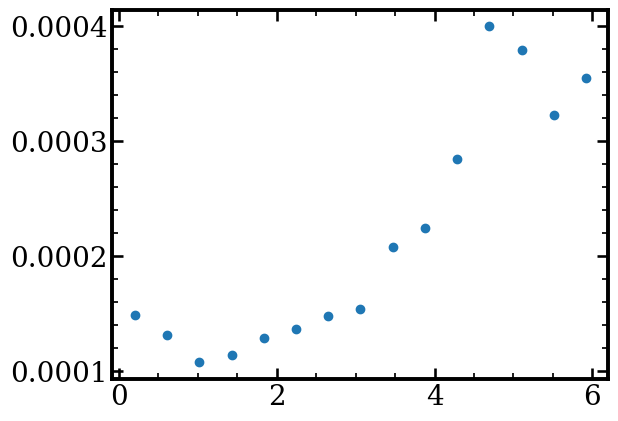

In [51]:
plt.scatter(pos,grad)

# Next step: Calculate circular angular momentum from interpolated potential gradient

In [9]:
# Need to check if this is correct: Calculating only based on x-y distance from subhalo center
# If the star is in the disk, nearly all the angular momentum should be due to motion in the x-y plane
grad_phi_interp = gradient_interp(r)

v_circ = np.sqrt(r * grad_phi_interp)

In [25]:
j_circ = r * v_circ
j_z = np.cross(star_coord_trans,star_vel_trans)[:,2]

In [27]:
ratio=j_z/j_circ
ratio

array([-7746.91129506,   439.19876237,   -23.40950098, ...,
                  nan,            nan,            nan])

In [32]:
np.min(ratio[~np.isnan(ratio)])

-23465.26587146074

In [33]:
np.max(ratio[~np.isnan(ratio)])

36843.648237636844

This is not correct...